<a href="https://colab.research.google.com/github/fidelis2025/stankelly-website/blob/main/Abdalla_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymc arviz pmdarima geopandas folium openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 16.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Upload file manually
from google.colab import files
import pandas as pd

uploaded = files.upload()  # This lets you pick file from your PC
file_path = list(uploaded.keys())[0]  # Automatically use uploaded filename

# Step 2: Read dataset
# Use pd.read_excel for .xlsx files
data = pd.read_excel(file_path)

Saving UCrime_Dataset.xlsx to UCrime_Dataset (1).xlsx


Import Libraries, Load and Prepare Dataset, and Basic Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pmd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Upload file manually in Colab before running
df = pd.read_excel("UCrime_Dataset.xlsx")

# Ensure correct data types
df["Year"] = df["Year"].astype(int)
df["Region"] = df["Region"].astype(str)

# Recalculate crime rate (to verify consistency)
df["Computed_Crime_Rate"] = (df["Total_Crime_Cases"] / df["Population"]) * 100000

# Replace existing rate with computed if needed
df["Crime_Rate"] = df["Computed_Crime_Rate"]

df = df.sort_values(["Region","Year"])
df.reset_index(drop=True, inplace=True)

df.head()

,Region,Year,Total_Crime_Cases,Population,Crime_Rate_per_100k,Crime_Category,Urbanization_Rate,Unemployment_Rate,Poverty_Index,Computed_Crime_Rate,Crime_Rate
0,Albertine,2019,9890.0,42999637,23.000194,Land-related Cases,5.509,3.060,17.7,23.000194,23.000194
1,Albertine,2020,10431.0,44457152,23.463041,Land-related Cases,12.846,3.831,19.5,23.463041,23.463041
2,Albertine,2021,11186.0,45910929,24.364569,Land-related Cases,4.417,3.422,78.6,24.364569,24.364569
3,Albertine,2022,13544.0,47312719,28.626552,Land-related Cases,11.076,2.886,33.8,28.626552,28.626552
4,Albertine,2023,12548.0,48656601,25.788896,Land-related Cases,24.954,2.787,23.5,25.788896,25.788896


Descriptive statistics and correlation heatmap

=== Descriptive Statistics ===
                     count        mean        std         min         25%  \
Year                180.00     2021.50       1.71     2019.00     2020.00   
Total_Crime_Cases   180.00     7166.64    3775.96      537.00     4518.00   
Population          180.00 46558688.33 2401794.71 42999637.00 44457152.00   
Crime_Rate_per_100k 180.00       15.41       8.01        1.07        9.54   
Urbanization_Rate   180.00       13.66       6.83        4.42        7.12   
Unemployment_Rate   180.00        3.15       0.36        2.79        2.89   
Poverty_Index       180.00       31.02      15.77       13.00       19.50   

                            50%         75%         max  
Year                    2021.50     2023.00     2024.00  
Total_Crime_Cases       6170.50     9520.00    17995.00  
Population          46611824.00 48656601.00 50015092.00  
Crime_Rate_per_100k       13.42       20.51       37.21  
Urbanization_Rate         12.67       19.00       27.39  
Unem

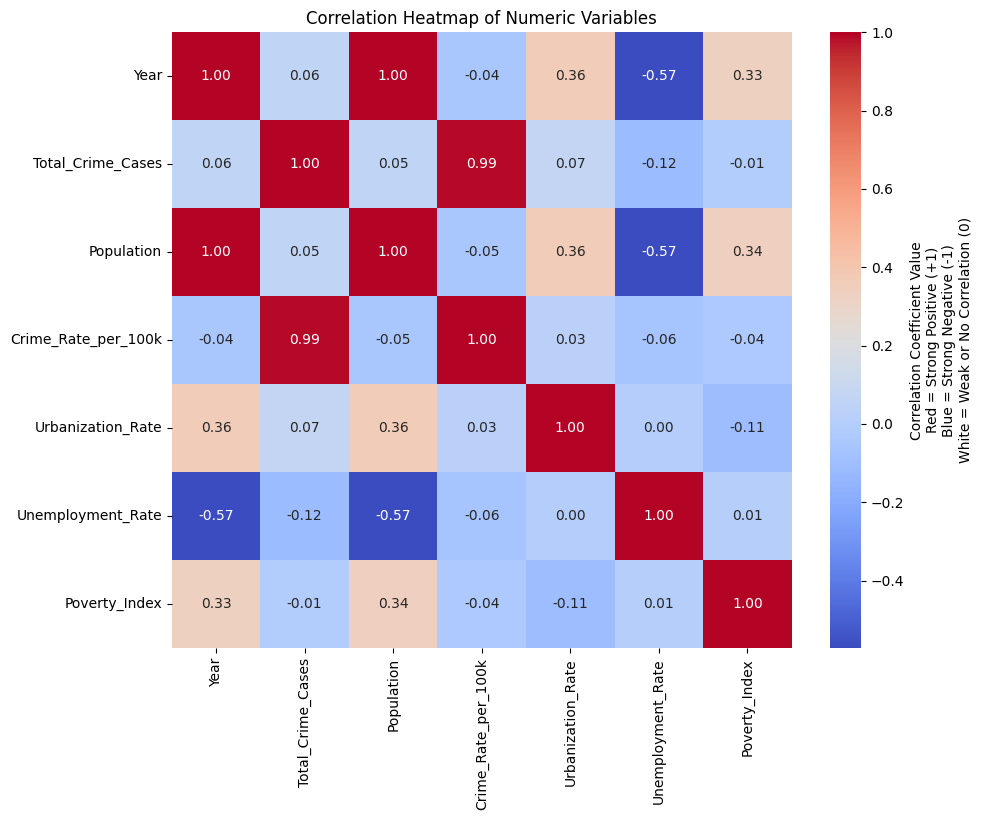

In [55]:
# -----------------------------
# Descriptive Statistics
# -----------------------------
print("=== Descriptive Statistics ===")

# Drop unwanted variables first
df_clean = df.drop(columns=["Computed_Crime_Rate", "Crime_Rate"], errors="ignore")

desc_stats = df_clean.describe().T
print(desc_stats)


# -----------------------------
# Correlation Matrix & Heatmap
# -----------------------------

# Select only numeric columns AFTER dropping unwanted ones
numeric_cols = df_clean.select_dtypes(include=np.number).columns
corr_matrix = df_clean[numeric_cols].corr()

print("\n=== Correlation Matrix ===")
print(corr_matrix)


# Heatmap
plt.figure(figsize=(10,8))

heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True
)

plt.title("Correlation Heatmap of Numeric Variables")

# Add clear explanation for color bar
cbar = heatmap.collections[0].colorbar
cbar.set_label("Correlation Coefficient Value\n"
               "Red = Strong Positive (+1)\n"
               "Blue = Strong Negative (-1)\n"
               "White = Weak or No Correlation (0)")

plt.show()

OBJECTIVE i: Bayesian Hierarchical Model for Regional Disparities

Output()

ERROR:pymc.stats.convergence:There were 1668 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


               mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha         9.331  0.079     9.130      9.484      0.022    0.024      11.0   
beta_poverty -0.002  0.000    -0.002     -0.002      0.000    0.000       4.0   
beta_unemp   -0.165  0.002    -0.170     -0.161      0.000    0.001      27.0   
beta_urban    0.002  0.000     0.002      0.002      0.000    0.000      13.0   
sigma_region  0.540  0.076     0.447      0.710      0.030    0.010       7.0   
u[0]          0.569  0.080     0.413      0.775      0.024    0.023      10.0   
u[1]         -0.469  0.080    -0.624     -0.262      0.025    0.023      11.0   
u[2]         -0.136  0.080    -0.289      0.074      0.025    0.023      10.0   
u[3]         -0.347  0.080    -0.502     -0.137      0.025    0.023      11.0   
u[4]         -0.144  0.080    -0.303      0.060      0.024    0.023      11.0   
u[5]          0.046  0.080    -0.112      0.253      0.024    0.023      11.0   
u[6]         -0.002  0.080  

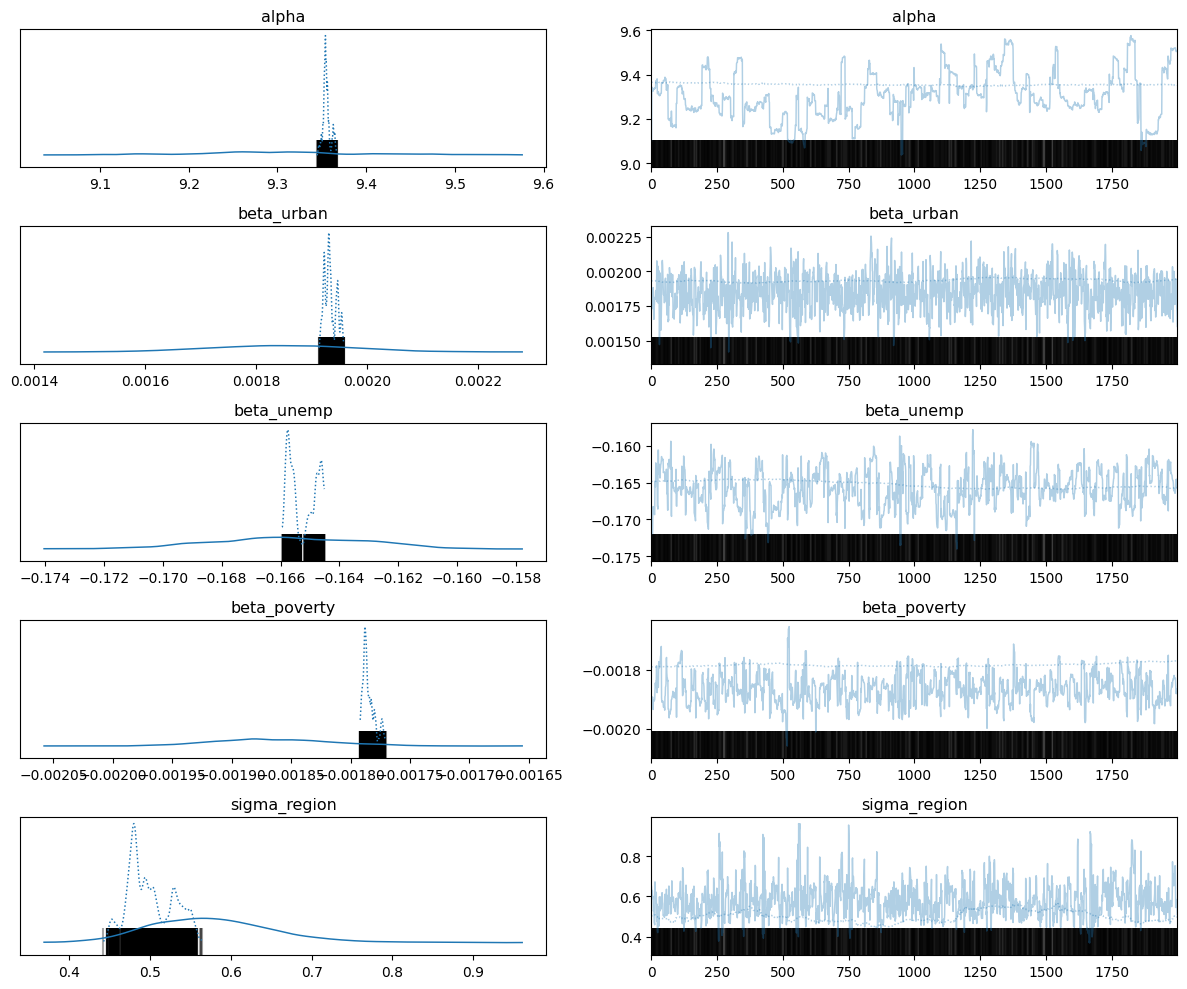

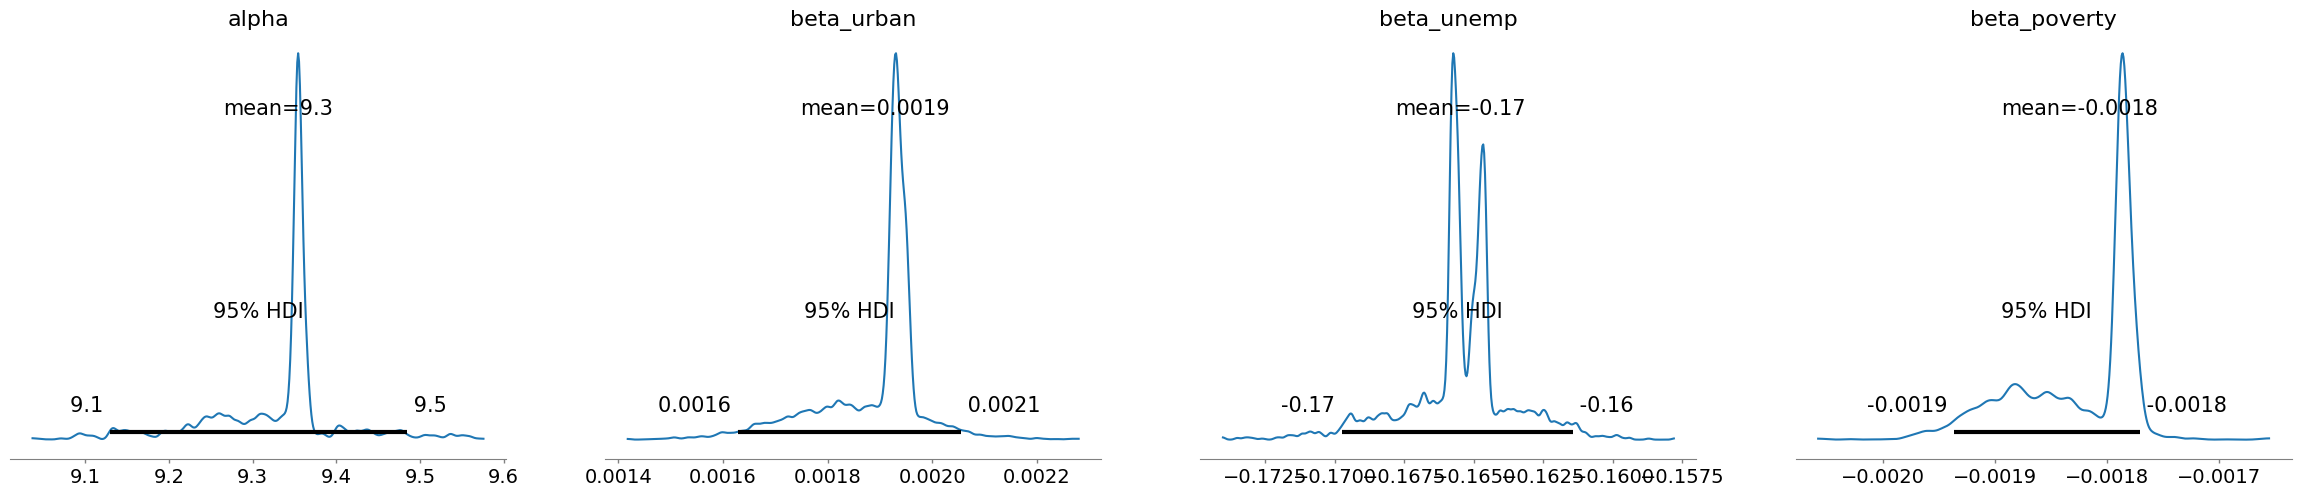

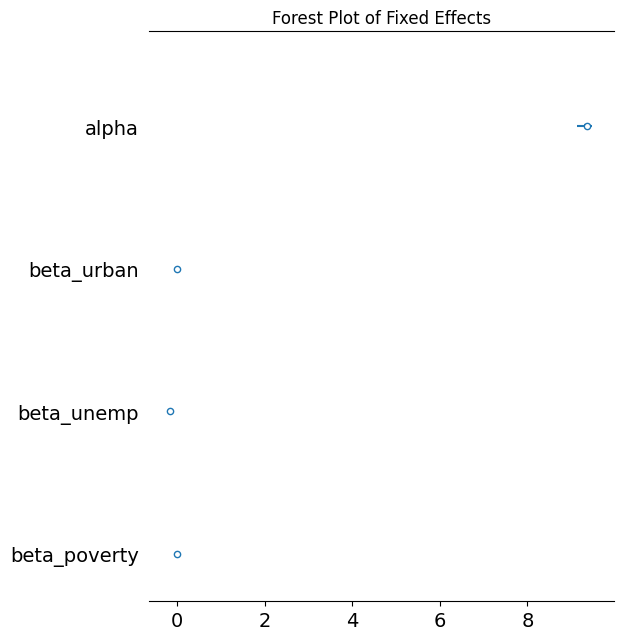

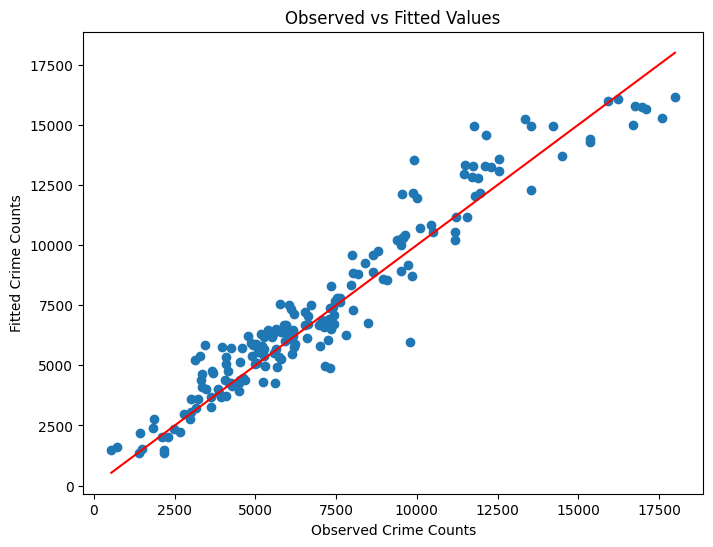

Output()

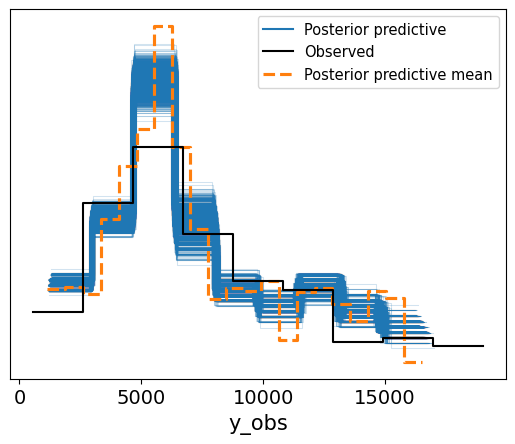

TypeError: unsupported operand type(s) for -: 'float' and 'method'

<Figure size 1000x600 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pmd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# Data Preparation
# -----------------------------
regions = df["Region"].unique()
region_idx = df["Region"].astype("category").cat.codes.values
n_regions = len(regions)

crime_counts = df["Total_Crime_Cases"].values
population = df["Population"].values
urban = df["Urbanization_Rate"].values
unemployment = df["Unemployment_Rate"].values
poverty = df["Poverty_Index"].values

# -----------------------------
# Bayesian Hierarchical Model
# -----------------------------
with pm.Model() as bhm:

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_urban = pm.Normal("beta_urban", mu=0, sigma=10)
    beta_unemp = pm.Normal("beta_unemp", mu=0, sigma=10)
    beta_poverty = pm.Normal("beta_poverty", mu=0, sigma=10)

    sigma_region = pm.HalfNormal("sigma_region", sigma=5)

    u = pm.Normal("u", mu=0, sigma=sigma_region, shape=n_regions)

    log_lambda = (
        alpha +
        beta_urban * urban +
        beta_unemp * unemployment +
        beta_poverty * poverty +
        u[region_idx]
    )

    lambda_ = pm.math.exp(log_lambda)

    y_obs = pm.Poisson("y_obs", mu=lambda_, observed=crime_counts)

    trace = pm.sample(2000, tune=1000, target_accept=0.9)
    az.summary(trace)

# -----------------------------
# 1️⃣ Model Summary
# -----------------------------
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# -----------------------------
# 2️⃣ Trace Plots (Convergence Check)
# -----------------------------
az.plot_trace(trace, var_names=["alpha","beta_urban","beta_unemp","beta_poverty","sigma_region"])
plt.tight_layout()
plt.show()

# -----------------------------
# 3️⃣ Posterior Density Plots
# -----------------------------
az.plot_posterior(trace, var_names=["alpha","beta_urban","beta_unemp","beta_poverty"],
                  hdi_prob=0.95)
plt.show()

# -----------------------------
# 4️⃣ Forest Plot for Fixed Effects
# -----------------------------
az.plot_forest(trace, var_names=["alpha","beta_urban","beta_unemp","beta_poverty"],
               combined=True, hdi_prob=0.95)
plt.title("Forest Plot of Fixed Effects")
plt.show()

# -----------------------------
# 7️⃣ Observed vs Fitted Plot (FIXED PROPERLY)
# -----------------------------

# Extract posterior means correctly
alpha_mean = trace.posterior["alpha"].mean(dim=("chain", "draw")).values
beta_urban_mean = trace.posterior["beta_urban"].mean(dim=("chain", "draw")).values
beta_unemp_mean = trace.posterior["beta_unemp"].mean(dim=("chain", "draw")).values
beta_poverty_mean = trace.posterior["beta_poverty"].mean(dim=("chain", "draw")).values

# Linear predictor
linear_pred = (
    alpha_mean
    + beta_urban_mean * urban
    + beta_unemp_mean * unemployment
    + beta_poverty_mean * poverty
    + region_effects[region_idx]
)

# Convert from log scale
fitted = np.exp(linear_pred)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(crime_counts, fitted)

plt.plot([crime_counts.min(), crime_counts.max()],
         [crime_counts.min(), crime_counts.max()],
         color='red')

plt.xlabel("Observed Crime Counts")
plt.ylabel("Fitted Crime Counts")
plt.title("Observed vs Fitted Values")
plt.show()

# -----------------------------
# 6️⃣ Posterior Predictive Check (FIXED)
# -----------------------------
with bhm:
    idata_ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

az.plot_ppc(idata_ppc)
plt.show()

# -----------------------------
# 5️⃣ Regional Random Effects Plot (CORRECTED)
# -----------------------------

# Posterior mean
region_effects = trace.posterior["u"].mean(dim=("chain", "draw")).values

# Compute HDI
# Correct extraction using index positions
region_hdi = az.hdi(trace.posterior["u"], hdi_prob=0.95)

lower_hdi = region_hdi.sel(hdi="lower").values
upper_hdi = region_hdi.sel(hdi="higher").values

# DataFrame
region_df = pd.DataFrame({
    "Region": regions,
    "Mean_Effect": region_effects,
    "Lower_HDI": lower_hdi,
    "Upper_HDI": upper_hdi
})

# Plot
plt.figure(figsize=(10,6))

plt.errorbar(
    region_df["Mean_Effect"],
    region_df["Region"],
    xerr=[
        region_df["Mean_Effect"] - region_df["Lower_HDI"],
        region_df["Upper_HDI"] - region_df["Mean_Effect"]
    ],
    fmt='o'
)

plt.axvline(0, color='red', linestyle='--')
plt.title("Regional Random Effects with 95% Credible Intervals")
plt.xlabel("Effect Size")
plt.ylabel("Region")
plt.show()

OBJECTIVE ii: ARIMA Model for Temporal Trends

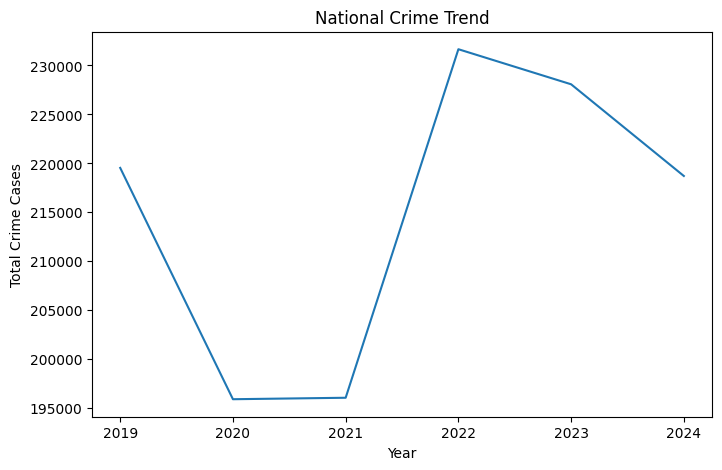

ADF Statistic: -1.6933245132259493
p-value: 1
Series is NOT stationary. Applying first differencing.
ADF after differencing: -1.8557688617002779
p-value after differencing: 0


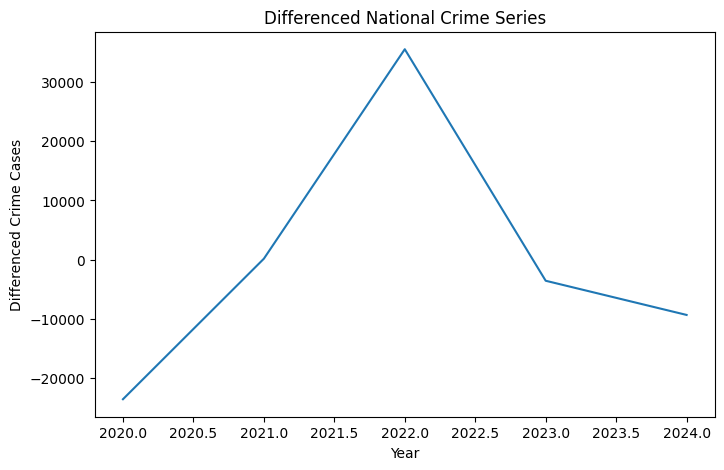

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=79.460, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=77.012, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=77.464, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=75.478, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.434 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    5
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -36.739
Date:                Fri, 27 Feb 2026   AIC                             75.478
Time:                        14:43:49   BIC                             74.577
Sample:                             0   HQIC                            73.666
                                  - 5                                         
Covariance

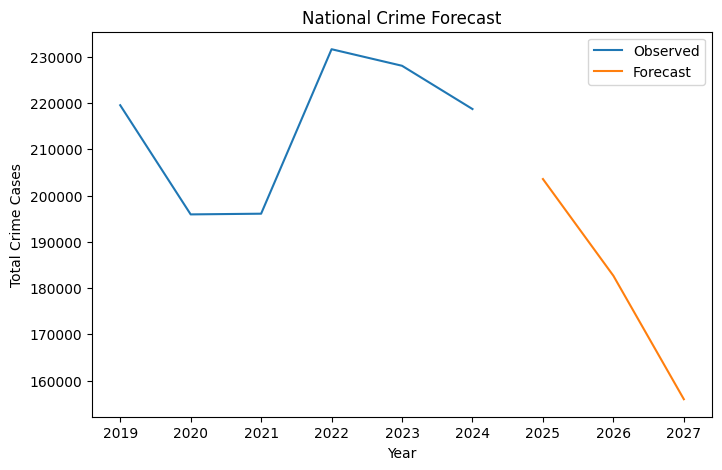

In [52]:
# Upload file manually in Colab before running
df = pd.read_excel("UCrime_Dataset.xlsx")

# Ensure correct data types
df["Year"] = df["Year"].astype(int)
df["Region"] = df["Region"].astype(str)

# Recalculate crime rate (to verify consistency)
df["Computed_Crime_Rate"] = (df["Total_Crime_Cases"] / df["Population"]) * 100000

# Replace existing rate with computed if needed
df["Crime_Rate"] = df["Computed_Crime_Rate"]

df = df.sort_values(["Region","Year"])
df.reset_index(drop=True, inplace=True)

# -----------------------------
# 1. Aggregate National Series
# -----------------------------
national_ts = df.groupby("Year")["Total_Crime_Cases"].sum()
national_ts = national_ts.sort_index()

plt.figure(figsize=(8,5))
plt.plot(national_ts)
plt.title("National Crime Trend")
plt.xlabel("Year")
plt.ylabel("Total Crime Cases")
plt.show()


# -----------------------------
# 2. ADF Stationarity Test
# -----------------------------
result = adfuller(national_ts)

print("ADF Statistic:", result[0])
print("p-value:", result[2])

# -----------------------------
# 3. Differencing if Needed
# -----------------------------
if result[1] > 0.05:
    print("Series is NOT stationary. Applying first differencing.")

    national_ts_diff = national_ts.diff().dropna()

    # Re-test
    result_diff = adfuller(national_ts_diff)

    print("ADF after differencing:", result_diff[0])
    print("p-value after differencing:", result_diff[2])

    ts_for_model = national_ts_diff
    d_value = 2

    plt.figure(figsize=(8,5))
    plt.plot(national_ts_diff)
    plt.title("Differenced National Crime Series")
    plt.xlabel("Year")
    plt.ylabel("Differenced Crime Cases")
    plt.show()

else:
    print("Series is stationary. No differencing needed.")
    ts_for_model = national_ts
    d_value = 0


# -----------------------------
# 4. Fit ARIMA Model
# -----------------------------
model = pmd.auto_arima(
    ts_for_model,
    d=d_value,
    seasonal=False,
    trace=True,
    stepwise=True,
    suppress_warnings=True
)

print(model.summary())


# -----------------------------
# 5. Forecasting
# -----------------------------
n_forecast = 3

forecast, conf_int = model.predict(n_periods=n_forecast, return_conf_int=True)

last_year = national_ts.index.max()
years_forecast = np.arange(last_year + 1, last_year + 1 + n_forecast)
print(years_forecast)

# -----------------------------
# 6. If Differenced, Convert Forecast Back to Original Scale
# -----------------------------
if d_value == 2:

    # Start from last observed actual value
    last_actual = national_ts.iloc[-1]

    forecast_original = []

    for value in forecast:
        last_actual = last_actual + value
        forecast_original.append(last_actual)

    forecast_original = np.array(forecast_original)

else:
    forecast_original = forecast


# -----------------------------
# 7. Plot Observed vs Forecast
# -----------------------------
plt.figure(figsize=(8,5))

plt.plot(national_ts.index, national_ts, label="Observed")
plt.plot(years_forecast, forecast_original, label="Forecast")

plt.title("National Crime Forecast")
plt.xlabel("Year")
plt.ylabel("Total Crime Cases")
plt.legend()
plt.show()

OBJECTIVE iii: Integrated Spatio-Temporal Hybrid Model

OBJECTIVE iv: Model Evaluation and Policy Relevance

In [57]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pmd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure all rows are printed in DataFrame outputs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ==========================================================
# 1️⃣ SPATIAL EFFECT SUMMARY
# ==========================================================

# Posterior mean of regional effects
region_effects = trace.posterior["u"].mean(dim=("chain","draw")).values

region_effects_df = pd.DataFrame({
    "Region": regions,
    "Spatial_Effect": region_effects
})

print("\n========== SPATIAL EFFECT SUMMARY ==========")
print(region_effects_df.sort_values("Spatial_Effect", ascending=False))

# ==========================================================
# 2️⃣ ARIMA TRAIN TEST SPLIT
# ==========================================================
train = national_ts[:-2]
test = national_ts[-2:]

model_train = pmd.auto_arima(train, seasonal=False)
pred_test_arima = model_train.predict(n_periods=2)

# ==========================================================
# 3️⃣ HYBRID MODEL PREDICTION FOR TEST PERIOD
# ==========================================================
avg_spatial_multiplier = np.mean(np.exp(region_effects))
pred_test_hybrid = pred_test_arima * avg_spatial_multiplier

# ==========================================================
# 4️⃣ ACCURACY FUNCTION
# ==========================================================
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, mse, rmse, mape

mae_arima, mse_arima, rmse_arima, mape_arima = evaluate_model(test, pred_test_arima)
mae_hybrid, mse_hybrid, rmse_hybrid, mape_hybrid = evaluate_model(test, pred_test_hybrid)

print("\n========== MODEL ACCURACY COMPARISON ==========")
print("\nARIMA Model Performance")
print("MAE :", mae_arima)
print("MSE :", mse_arima)
print("RMSE:", rmse_arima)
print("MAPE:", mape_arima)

print("\nHybrid Model Performance")
print("MAE :", mae_hybrid)
print("MSE :", mse_hybrid)
print("RMSE:", rmse_hybrid)
print("MAPE:", mape_hybrid)

# ==========================================================
# 5️⃣ 5-YEAR FORECAST USING ARIMA
# ==========================================================
future_periods = 5
future_forecast_arima = model_train.predict(n_periods=future_periods)
future_years = np.arange(national_ts.index.max() + 1,
                         national_ts.index.max() + 1 + future_periods)

# ==========================================================
# 6️⃣ REGIONAL HYBRID FORECAST (5 YEARS)
# ==========================================================
hybrid_forecast = []

for i, region in enumerate(regions):
    spatial_multiplier = np.exp(region_effects[i])
    regional_projection = future_forecast_arima * spatial_multiplier

    for j in range(future_periods):
        hybrid_forecast.append([
            region,
            future_years[j],
            regional_projection.iloc[j] # Use .iloc for positional indexing
        ])

hybrid_forecast_df = pd.DataFrame(
    hybrid_forecast,
    columns=["Region", "Year", "Forecasted_Crime_Rate"]
)

# Print all forecasted values without truncation
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

print("\n========== 5-YEAR REGIONAL HYBRID FORECAST ==========")
print(hybrid_forecast_df)

# ==========================================================
# 7️⃣ VULNERABILITY CLASSIFICATION
# ==========================================================
latest_year = df["Year"].max()
latest_rates = df[df["Year"] == latest_year][["Region","Crime_Rate"]]

q33 = latest_rates["Crime_Rate"].quantile(0.33)
q66 = latest_rates["Crime_Rate"].quantile(0.66)

def classify(rate):
    if rate <= q33:
        return "Low"
    elif rate <= q66:
        return "Moderate"
    else:
        return "High"

latest_rates["Vulnerability_Status"] = latest_rates["Crime_Rate"].apply(classify)

print("\n========== REGIONAL VULNERABILITY STATUS ==========")
print(latest_rates.sort_values("Crime_Rate", ascending=False))


========== SPATIAL EFFECT SUMMARY ==========
                Region  Spatial_Effect
20         North Kyoga            0.79
24               Rwizi            0.78
13           KMP North            0.78
14           KMP South            0.68
0            Albertine            0.57
11      Greater Masaka            0.56
12            KMP East            0.41
8           East Kyoga            0.37
23       Rwenzori West            0.33
9                Elgon            0.22
29           West Nile            0.09
17              Kigezi            0.06
5          Busoga East            0.05
6         Busoga North           -0.00
28              Wamala           -0.06
27                Sipi           -0.06
25            Savannah           -0.08
10    Greater Bushenyi           -0.13
2            Aswa West           -0.14
4         Bukedi South           -0.14
26             Sezibwa           -0.20
15             Katonga           -0.23
3         Bukedi North           -0.35
19           Mt Mo

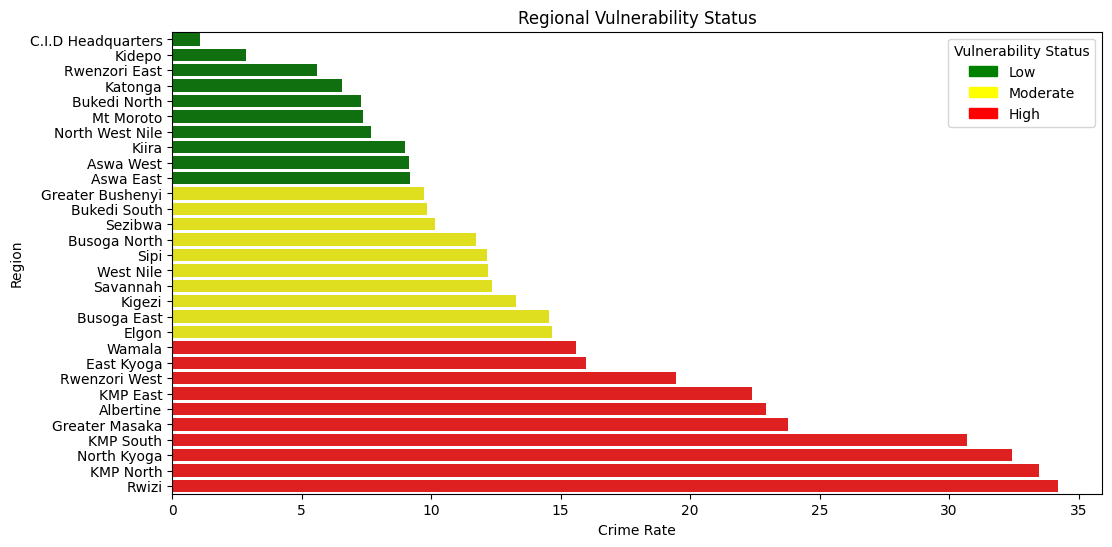

In [51]:
# ==========================================================
# 8️⃣ PLOT REGIONAL VULNERABILITY STATUS WITH KEY
# ==========================================================
import matplotlib.patches as mpatches

# Define colors
color_map = {"Low": "green", "Moderate": "yellow", "High": "red"}

# Sort by crime rate for better visual ordering
latest_rates_sorted = latest_rates.sort_values("Crime_Rate", ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Crime_Rate",
    y="Region",
    data=latest_rates_sorted,
    palette=latest_rates_sorted["Vulnerability_Status"].map(color_map).tolist()
)

# Add labels and title
plt.xlabel("Crime Rate")
plt.ylabel("Region")
plt.title(f"Regional Vulnerability Status")

# Create legend (key)
patches = [mpatches.Patch(color=color, label=status)
           for status, color in color_map.items()]
plt.legend(handles=patches, title="Vulnerability Status", loc="upper right")

plt.show()